In [192]:
import pandas as pd

Loading the data as a dataframe, using pandas

In [193]:
data_path = 'sample_data/SMSSpamCollection'

# separating the category and messages
df = pd.read_csv(data_path, sep='\t')

# adding headers (i.e., category and message) to the dataframe
df.columns = ['category', 'message']

In [194]:
df.astype({'message': str, 'category': 'category'})

,category,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
...,...,...
5566,spam,This is the 2nd time we have tried 2 contact u...
5567,ham,Will ü b going to esplanade fr home?
5568,ham,"Pity, * was in mood for that. So...any other s..."
5569,ham,The guy did some bitching but I acted like i'd...


Exploring the data

In [195]:
# showing the first 5 samples of the dataset to explore its structure
df.head()

,category,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [196]:
# change category labels to numbers (1 for spam, 0 otherwise)
change_labels = lambda label: 1 if label == 'spam' else 0

In [197]:
# applying the above function on the dataframe
df['category'] = df['category'].apply(change_labels)

In [198]:
# Now, the category column is shown as numbers
df.head()

,category,message
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...


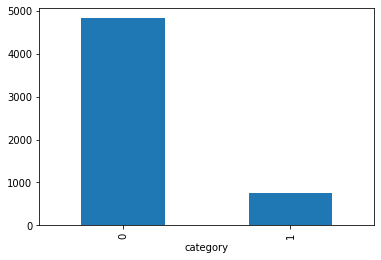

In [199]:
# check if the data is balanced or imbalanced (group the samples based on their category)
df.groupby(['category']).size().plot.bar()

In [200]:
# Number of occurrence for each category
df.groupby(by=['category']).count()

,message
category,
0,4824
1,747


The data is imbalanced, so we will do oversampling to make it balanced

In [201]:
# find maximum number of samples that the major category has
max_size = df['category'].value_counts().max()
print(max_size)

4824


Oversampling (to balance the dataset)

In [202]:
# increase the number of the minor class by sampling with replacement to have the same number as of the major category
oversample = [df]
# for all the existing categories
for category_idx, category in df.groupby(['category']):
    # count the number of samples needed to get the exact number of samples equal to the major category
    # sample that number from the current category, with replacement
    oversample.append(category.sample(max_size - len(category), replace = True))
# add the new samples to the original dataset
oversample_df = pd.concat(oversample)

In [203]:
# again, check the number of occurrence for each category
oversample_df.groupby(by=['category']).count()

,message
category,
0,4824
1,4824


The resulting dataset is balanced now 
**Result: the number of spam and non-spam messages match**

Data pre-processing
* stemming
* lemmatizing

In [204]:
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [205]:
# stemming
porter_stemmer = PorterStemmer()
stem = lambda message: [porter_stemmer.stem(word) for word in message.split()]

In [206]:
# lemmatizing
word_net_lemmatizer = WordNetLemmatizer()
lemmatizer = lambda message: [word_net_lemmatizer.lemmatize(word) for word in message]

In [207]:
# applying stemming and lemmatizing to preprocess the data
print('processing srarted')
oversample_df['message'] = oversample_df['message'].apply(stem)
oversample_df['message'] = oversample_df['message'].apply(lemmatizer)
oversample_df['message'] = oversample_df['message'].apply(lambda message: ' '.join(message))
print('preprocessing completed')

processing srarted
preprocessing completed


In [208]:
oversample_df.head()

,category,message
0,0,ok lar... joke wif u oni...
1,1,free entri in 2 a wkli comp to win fa cup fina...
2,0,u dun say so earli hor... u c alreadi then say...
3,0,"nah i don't think he goe to usf, he live aroun..."
4,1,freemsg hey there darl it' been 3 week' now an...


In [209]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [210]:
from transformers import BertTokenizer

In [211]:
# store the dataset as samples (i.e., preprocessed samples that are tokenized with pre-trained BERT) and their corresponding labels
import torch
import numpy as np
from transformers import BertTokenizer

torch.cuda.empty_cache()

# tokenizes the sentence from pre-trained model BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # tokenize the pre-processed messages in the dataframe, following the specified parameters
        self.messages = [tokenizer(message, padding = 'max_length', max_length = 512, truncation = True,
                                   return_tensors = "pt") for message in df['message']]
        # retrieve the labels of the categories
        self.labels = [label for label in df['category']]
        
    def __len__(self):
        # number of samples in the dataset
        return len(self.labels)
    
    def count_spam(self):
        # count the total number of spam messages in the dataset
        return sum(self.labels)
        
    def get_batch_messages(self, idx):
        # batch of input messages
        return self.messages[idx]
    
    def get_batch_labels(self, idx):
        # batch of labels
        return self.labels[idx]
        
    def __getitem__(self, idx):
        batch_messages = self.get_batch_messages(idx)
        batch_labels = self.get_batch_labels(idx)
        
        # messages and their corresponding labels in the current batch
        return batch_messages, batch_labels
        

Split dataset into training, validation, and test set (i.e., 80, 10, 10, respectively)

In [212]:
# to split the dataset to train/dev/test
from sklearn.model_selection import train_test_split

In [213]:
# shuffle the dataframe
oversample_df = oversample_df.sample(frac=1, random_state=42)

In [214]:
# splitting step
df_train, _df_val_test = train_test_split(oversample_df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(_df_val_test, test_size=0.5, random_state=42)

In [215]:
print('train_size: ', len(df_train), ', val_size: ', len(df_val), ', test_size: ', len(df_test))

train_size:  8683 , val_size:  482 , test_size:  483


Building the network model

In [216]:
from torch import nn
from transformers import BertModel

class binary_classifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(binary_classifier, self).__init__()
        
        # pre-trained BERT model (12 layers Transformer encoder)
        self.bert = BertModel.from_pretrained('bert-base-cased')
        # dropout layer (for regularization)
        self.dropout = nn.Dropout(dropout)
        # linear layer for the last layer, vector of size 1 is used because the task is a binary classification
        self.linear = nn.Linear(768, 1)
        # relu activation
        self.relu = nn.ReLU()
        
    def forward(self, input_id, attention_mask):
        # all_output: embedding vectors for all the tokens in a sentence
        # cls_output: embedding vector of [cls] token (used as the input to the classifier)
        all_output, cls_output = self.bert(input_ids = input_id, attention_mask = attention_mask, return_dict = False)
        # dropout layer
        output = self.dropout(cls_output)
        # linear layer
        output = self.linear(output)
        # relu function
        output = self.relu(output)
        
        return output
        

Trianing the model

In [217]:
# function to compute the accuracy of the model
def binary_accuracy(pred, actual_label):
    # apply sigmoid function on the output of the network to get the exact label
    pred_label = torch.round(torch.sigmoid(pred))
    
    # compare the predicted and the actual labels together to find True Positive and True Negative
    # count the ones that match
    accuracy = (pred_label == actual_label).sum().float()
    
    return accuracy


In [218]:
from torch.utils import data
from torch.optim import Adam

def train(model, train_data, val_data, learning_rate, n_epochs):
    # change the dataframe to the desired dataet format
    train_data = dataset(train_data)
    val_data = dataset(val_data)
    
    # iterate over the dataset
    train_dataloader = data.DataLoader(train_data, batch_size=8, shuffle=True)
    val_dataloader = data.DataLoader(val_data, batch_size=8)
    
    # GPU/CPU usage based on its availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # binary classification cross entropy loss (including a sigmoid layer)
    criterion = nn.BCEWithLogitsLoss()
    # adam optimizer (momentum)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    # if GPU is available use it for the model and loss part
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        

    # store the train/val loss and accuracy for each epoch
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    # train the model for the number of epochs
    # each epoch demonstrates the number of times we will go through the whole dataset
    for epoch in range(n_epochs):
        
        # training phase
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        
        # switch to behave differently for train and inference (i.e., Dropout)
        model.train()
        # training phase for each mini-batch
        for train_message, train_label in train_dataloader:
            # id representation of each token in the input sequence
            input_id = train_message['input_ids'].squeeze(1).to(device)
            # determine if a token is a real word or just padding (padding 0, otherwise 1)
            attention_mask = train_message['attention_mask'].to(device)
            # category label of the input
            train_label = train_label.to(device)
            
            # based on the input sequence and the model, compute the output
            output = model(input_id, attention_mask)
            
            # based on the assigned loss, compute the distance between current output of the model with its true output, that is given in the dataset
            cur_loss = criterion(output, train_label.unsqueeze(1).float())
            epoch_train_loss += cur_loss.item()
            
            # compute how the model accurately predicts the output
            cur_accuracy = binary_accuracy(output, train_label.unsqueeze(1))
            epoch_train_accuracy += cur_accuracy.item()
            
            # making sure all the gradients are zero
            # if not, the model will accumulate all the gradients on each call of the loss.backward()
            model.zero_grad()
            # compute the derivative of loss for each parameter and accumulate to the gradient
            # store the gradient tensors
            cur_loss.backward()
            # update the value of the weights of the features
            optimizer.step()

        train_loss.append(epoch_train_loss / len(train_data))
        train_accuracy.append(epoch_train_accuracy / len(train_data))
            
        # validation phase
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        
        # switch to behave differently for train and inference (i.e., Dropout)
        model.eval()
        # evaluation does not need computing the gradients
        with torch.no_grad():
            # the following steps are like the ones in training
            # except there is no need to compute the gradients and updating the weights of the features
            for val_message, val_label in val_dataloader:
                input_id = val_message['input_ids'].squeeze(1).to(device)
                attention_mask = val_message['attention_mask'].to(device)
                val_label = val_label.to(device)
                
                output = model(input_id, attention_mask)
                
                cur_loss = criterion(output, val_label.unsqueeze(1).float())
                epoch_val_loss += cur_loss.item()
                
                cur_accuracy = binary_accuracy(output, val_label.unsqueeze(1))
                epoch_val_accuracy += cur_accuracy.item()
                
        val_loss.append(epoch_val_loss / len(val_data))
        val_accuracy.append(epoch_val_accuracy / len(val_data))
        
        print('Epoch: ', epoch+1, ' | Train Loss: ', epoch_train_loss / len(train_data),
              ' | Train Accuracy: ', epoch_train_accuracy / len(train_data), 
              ' | Val Loss: ', epoch_val_loss / len(val_data),
              ' | Val Accuracy: ', epoch_val_accuracy / len(val_data))
        
    print('train_loss: ', train_loss)
    print('val_loss: ', val_loss)
    print('train_accuracy: ', train_accuracy)
    print('val_accuracy: ', val_accuracy)
        

# number of epochs that the model should go through the whole dataset        
n_epochs = 10
model = binary_classifier(0.5)
# the learning rate of the features' weights
learning_rate = 1e-7

train(model, df_train, df_val, learning_rate, n_epochs)
        
            

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1  | Train Loss:  0.08699644362886669  | Train Accuracy:  0.4947598756190257  | Val Loss:  0.08772194632850742  | Val Accuracy:  0.5373443983402489
Epoch:  2  | Train Loss:  0.08594169889769905  | Train Accuracy:  0.5460094437406426  | Val Loss:  0.08649303272552016  | Val Accuracy:  0.7966804979253111
Epoch:  3  | Train Loss:  0.07729342777539848  | Train Accuracy:  0.7806057814119544  | Val Loss:  0.07135117220928065  | Val Accuracy:  0.9481327800829875
Epoch:  4  | Train Loss:  0.06823708171752772  | Train Accuracy:  0.8930093285730738  | Val Loss:  0.06442372037167371  | Val Accuracy:  0.9585062240663901
Epoch:  5  | Train Loss:  0.06217357455537737  | Train Accuracy:  0.9143153288034089  | Val Loss:  0.059645782553308734  | Val Accuracy:  0.9647302904564315
Epoch:  6  | Train Loss:  0.057642255222537915  | Train Accuracy:  0.9288264424737994  | Val Loss:  0.05646955364101655  | Val Accuracy:  0.9688796680497925
Epoch:  7  | Train Loss:  0.054059997164069076  | Train Accura

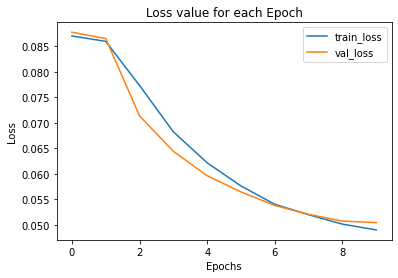

In [220]:
# plotting the train/val loss to observerve the underfitting/overfitting
import matplotlib.pyplot as plt

# the train/val loss lists generated during training
train_loss = [0.08699644362886669, 0.08594169889769905, 0.07729342777539848, 0.06823708171752772, 0.06217357455537737, 0.057642255222537915, 0.054059997164069076, 0.05201575915724619, 0.05017595295239247, 0.04904707130480167]
val_loss = [0.08772194632850742, 0.08649303272552016, 0.07135117220928065, 0.06442372037167371, 0.059645782553308734, 0.05646955364101655, 0.05382900128597046, 0.052092652165048846, 0.0507674685281342, 0.050473906779932284]

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss value for each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

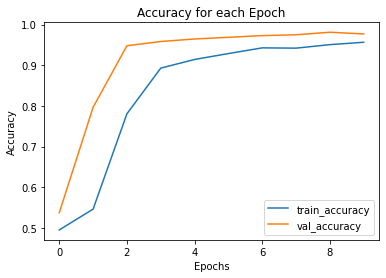

In [221]:
# plotting the train/val accuracy
import matplotlib.pyplot as plt

# the tran/val accuracy lists generated during training
train_accuracy = [0.4947598756190257, 0.5460094437406426, 0.7806057814119544, 0.8930093285730738, 0.9143153288034089, 0.9288264424737994, 0.9428768858689393, 0.9421858804560636, 0.9508234481170103, 0.956696994126454]
val_accuracy = [0.5373443983402489, 0.7966804979253111, 0.9481327800829875, 0.9585062240663901, 0.9647302904564315, 0.9688796680497925, 0.9730290456431535, 0.975103734439834, 0.9813278008298755, 0.9771784232365145]

plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy for each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

Evaluating the trained model on test set

In [222]:
def test(model, test_data):
    # all the steps are like before
    test_data = dataset(test_data)
    
    # iterate over the dataset
    test_dataloader = data.DataLoader(test_data, batch_size = 8)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if torch.cuda.is_available():
        model = model.cuda()
        
    total_test_accuracy = 0
    
    # switch to behave differently during train and inference
    model.eval()
    with torch.no_grad():
        for test_message, test_label in test_dataloader:
            input_id = test_message['input_ids'].squeeze(1).to(device)
            attention_mask = test_message['attention_mask'].to(device)
            test_label = test_label.to(device)
            
            output = model(input_id, attention_mask)
            
            cur_accuracy = binary_accuracy(output, test_label.unsqueeze(1).float())
            total_test_accuracy += cur_accuracy
            
    print('Test Accuracy: ', total_test_accuracy / len(test_data))
    
test(model, df_test)


Test Accuracy:  tensor(0.9772, device='cuda:0')
